In [2]:
% matplotlib inline

import logging
import sys

from neural_metrics import run as run_metrics

logging.basicConfig(stream=sys.stdout, level=logging.getLevelName("INFO"))


def run(*args, **kwargs):
    scores = run_metrics(*args, **kwargs)
    for score in scores:
        print("{} explanation: {}".format(score.name, score.explanation))


Using TensorFlow backend.


### Alexnet

INFO:neural_metrics:Computing activations


INFO:neural_metrics.models:Using cached activations: /mnt/c/Users/Martin/workspaces/dicarlo/neural-correlations/neural_metrics/models/../../images/sorted/alexnet-weights_imagenet-activations.pkl


INFO:neural_metrics:Computing scores


INFO:neural_metrics.metrics:Physiology mapping: V4 -> features.2,features.5,features.7 (0.56), IT -> features.9,features.12,classifier.2,classifier.5,classifier.6 (0.58)


INFO:neural_metrics:Plotting


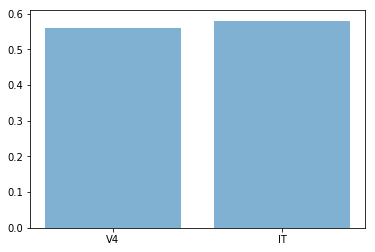

V4 explanation: ['features.2', 'features.5', 'features.7']
IT explanation: ['features.9', 'features.12', 'classifier.2', 'classifier.5', 'classifier.6']


In [3]:
run(model='alexnet', layers=['features.2', 'features.5', 'features.7', 'features.9', 'features.12', 
                             'classifier.2', 'classifier.5', 'classifier.6'])

### VGG16

INFO:neural_metrics:Computing activations


INFO:neural_metrics.models:Using cached activations: /mnt/c/Users/Martin/workspaces/dicarlo/neural-correlations/neural_metrics/models/../../images/sorted/vgg16-weights_imagenet-activations.pkl


INFO:neural_metrics:Computing scores


INFO:neural_metrics.metrics:Physiology mapping: V4 -> block1_pool,block2_pool,block3_pool (0.58), IT -> block4_pool,block5_pool,fc1,fc2 (0.57)


INFO:neural_metrics:Plotting


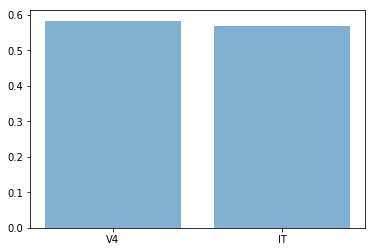

V4 explanation: ['block1_pool', 'block2_pool', 'block3_pool']
IT explanation: ['block4_pool', 'block5_pool', 'fc1', 'fc2']


In [5]:
run(model='vgg16', layers=['block1_pool', 'block2_pool', 'block3_pool', 'block4_pool', 'block5_pool', 
                           'fc1', 'fc2'])

In [6]:
run(model='vgg16', layers=['block1_pool', 'block2_pool', 'block3_pool', 'block4_pool', 'block5_pool', 
                           'fc1', 'fc2'],
    model_weights=None)

INFO:neural_metrics:Computing activations


INFO:neural_metrics.models.outputs:Computing layer outputs


KeyboardInterrupt: 

### ResNet50

INFO:neural_metrics:Computing activations


INFO:neural_metrics.models:Using cached activations: /mnt/c/Users/Martin/workspaces/dicarlo/neural-correlations/neural_metrics/models/../../images/sorted/resnet50-weights_imagenet-activations.pkl


INFO:neural_metrics:Computing scores


INFO:neural_metrics.metrics:Physiology mapping: V4 -> activation_1,activation_2,activation_3,activation_4,activation_5,activation_6,activation_7,activation_8,activation_9,activation_10,activation_11,activation_12,activation_13,activation_14,activation_15,activation_16,activation_17,activation_18,activation_19,activation_20,activation_21,activation_22,activation_23,activation_24,activation_25,activation_26,activation_27,activation_28 (0.57), IT -> activation_29,activation_30,activation_31,activation_32,activation_33,activation_34,activation_35,activation_36,activation_37,activation_38,activation_39,activation_40,activation_41,activation_42,activation_43,activation_44,activation_45,activation_46,activation_47,activation_48,activation_49 (0.61)


INFO:neural_metrics:Plotting


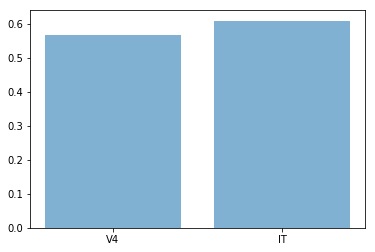

V4 explanation: ['activation_1', 'activation_2', 'activation_3', 'activation_4', 'activation_5', 'activation_6', 'activation_7', 'activation_8', 'activation_9', 'activation_10', 'activation_11', 'activation_12', 'activation_13', 'activation_14', 'activation_15', 'activation_16', 'activation_17', 'activation_18', 'activation_19', 'activation_20', 'activation_21', 'activation_22', 'activation_23', 'activation_24', 'activation_25', 'activation_26', 'activation_27', 'activation_28']
IT explanation: ['activation_29', 'activation_30', 'activation_31', 'activation_32', 'activation_33', 'activation_34', 'activation_35', 'activation_36', 'activation_37', 'activation_38', 'activation_39', 'activation_40', 'activation_41', 'activation_42', 'activation_43', 'activation_44', 'activation_45', 'activation_46', 'activation_47', 'activation_48', 'activation_49']


In [7]:
run(model='resnet50', layers=['activation_1', 'activation_2', 'activation_3', 'activation_4', 'activation_5', 
                              'activation_6', 'activation_7', 'activation_8', 'activation_9', 'activation_10', 
                              'activation_11', 'activation_12', 'activation_13', 'activation_14', 'activation_15', 
                              'activation_16', 'activation_17', 'activation_18', 'activation_19', 'activation_20', 
                              'activation_21', 'activation_22', 'activation_23', 'activation_24', 'activation_25', 
                              'activation_26', 'activation_27', 'activation_28', 'activation_29', 'activation_30', 
                              'activation_31', 'activation_32', 'activation_33', 'activation_34', 'activation_35', 
                              'activation_36', 'activation_37', 'activation_38', 'activation_39', 'activation_40', 
                              'activation_41', 'activation_42', 'activation_43', 'activation_44', 'activation_45', 
                              'activation_46', 'activation_47', 'activation_48', 'activation_49'])

### ResNet152

In [ ]:
run(model='resnet152', layers=['block1_pool', 'block2_pool', 'block3_pool', 'block4_pool', 'block5_pool', 
                           'fc1', 'fc2'])

### InceptionV3

INFO:neural_metrics:Computing activations


INFO:neural_metrics.models:Using cached activations: /mnt/c/Users/Martin/workspaces/dicarlo/neural-correlations/neural_metrics/models/../../images/sorted/inception_v3-weights_imagenet-activations.pkl


INFO:neural_metrics:Computing scores


INFO:neural_metrics.metrics:Physiology mapping: V4 -> mixed0,mixed1,mixed2,mixed3 (0.55), IT -> mixed4,mixed5,mixed6,mixed7,mixed8,mixed9,mixed10 (0.59)


INFO:neural_metrics:Plotting


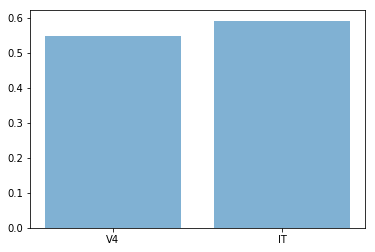

V4 explanation: ['mixed0', 'mixed1', 'mixed2', 'mixed3']
IT explanation: ['mixed4', 'mixed5', 'mixed6', 'mixed7', 'mixed8', 'mixed9', 'mixed10']


In [8]:
run(model='inception_v3', layers=['mixed0', 'mixed1', 'mixed2', 'mixed3', 'mixed4', 'mixed5', 
                                  'mixed6', 'mixed7', 'mixed8', 'mixed9', 'mixed10'])

### Squeezenet

INFO:neural_metrics:Computing activations


INFO:neural_metrics.models:Using cached activations: /mnt/c/Users/Martin/workspaces/dicarlo/neural-correlations/neural_metrics/models/../../images/sorted/squeezenet-weights_imagenet-activations.pkl


INFO:neural_metrics:Computing scores


INFO:neural_metrics.metrics:Physiology mapping: V4 -> fire5/concat,fire4/concat,fire3/concat,fire2/concat,pool1 (0.58), IT -> relu_conv10,fire9/concat,fire8/concat,fire7/concat,fire6/concat (0.58)


INFO:neural_metrics:Plotting


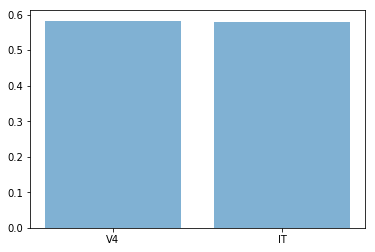

V4 explanation: ['fire5/concat', 'fire4/concat', 'fire3/concat', 'fire2/concat', 'pool1']
IT explanation: ['relu_conv10', 'fire9/concat', 'fire8/concat', 'fire7/concat', 'fire6/concat']


In [10]:
run(model='squeezenet', layers=['pool1', 'fire2/concat', 'fire3/concat', 'fire4/concat', 
                                'fire5/concat', 'fire6/concat', 'fire7/concat', 'fire8/concat', 
                                'fire9/concat', 'relu_conv10'])

### DenseNet

In [12]:
run(model='densenet', layers=['activation_1', 'activation_4', 'activation_7', 'activation_10', 'activation_13', 
                              'activation_16', 'activation_19', 'activation_22', 'activation_25', 'activation_28', 
                              'activation_31', 'activation_34', 'activation_37', 'activation_40', 'activation_43', 
                              'activation_46', 'activation_49', 'activation_52', 'activation_55', 'activation_58', 
                              'activation_61', 'activation_64', 'activation_67', 'activation_70', 'activation_73', 
                              'activation_76', 'activation_79', 'activation_82', 'activation_85', 'activation_88', 
                              'activation_91', 'activation_94', 'activation_97', 'activation_100', 'activation_103', 
                              'activation_106', 'activation_109', 'activation_112', 'activation_115', 'activation_118', 
                              'activation_121'])

INFO:neural_metrics:Computing activations


INFO:neural_metrics.models:Using cached activations: /mnt/c/Users/Martin/workspaces/dicarlo/neural-correlations/neural_metrics/models/../../images/sorted/densenet-weights_imagenet-activations.pkl


INFO:neural_metrics:Computing scores


ValueError: Operation 'IsVariableInitialized_1480' has been marked as not fetchable.

### MobileNet

In [13]:
run(model='mobilenet', layers=['conv1_relu', 'conv_dw_1_relu', 'conv_pw_1_relu', 
                               'conv_dw_2_relu', 'conv_pw_2_relu', 
                               'conv_dw_3_relu', 'conv_pw_3_relu', 
                               'conv_dw_4_relu', 'conv_pw_4_relu', 
                               'conv_dw_5_relu', 'conv_pw_5_relu', 
                               'conv_dw_6_relu', 'conv_pw_6_relu', 
                               'conv_dw_7_relu', 'conv_pw_7_relu', 
                               'conv_dw_8_relu', 'conv_pw_8_relu', 
                               'conv_dw_9_relu', 'conv_pw_9_relu', 
                               'conv_dw_10_relu', 'conv_pw_10_relu', 
                               'conv_dw_11_relu', 'conv_pw_11_relu', 
                               'conv_dw_12_relu', 'conv_pw_12_relu', 
                               'conv_dw_13_relu', 'conv_pw_13_relu', 
                               'global_average_pooling2d_1', 'act_softmax'])

INFO:neural_metrics:Computing activations


INFO:neural_metrics.models:Using cached activations: /mnt/c/Users/Martin/workspaces/dicarlo/neural-correlations/neural_metrics/models/../../images/sorted/mobilenet-weights_imagenet-activations.pkl


INFO:neural_metrics:Computing scores


ValueError: Operation 'IsVariableInitialized_3109' has been marked as not fetchable.